In [11]:
#importing required libraries.....

import os 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # regular expression
import matplotlib.pyplot as plt
import seaborn
import nltk
from nltk import PorterStemmer # natural language toolkit
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [12]:
os.listdir("input")

['train.csv', 'sample_submission.csv', 'test.csv']

In [ ]:
#read the data 
train=pd.read_csv('input/train.csv')
test=pd.read_csv('input/test.csv')
sample=pd.read_csv('input/sample_submission.csv')

In [19]:
#printing some upper rows of our training data
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [18]:
#some information about data
print('No. of training examples : ',len(train))
print("No. of test data : ",len(test))
print(train.columns[2:]) #columns_name
row=train.iloc[:,2:].sum(axis=1)
print("No. of examples with no labels : ",(row==0).sum())

No. of training examples :  159571
No. of test data :  153164
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
No. of examples with no labels :  143346


In [17]:
#fill blank values with unknown otherwise model gives problem
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


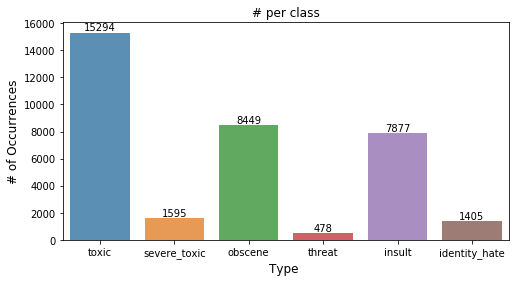

In [13]:
#plot
x=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= seaborn.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [14]:
# creating train-validation split
x_train, x_val, y_train, y_val = train_test_split(train.comment_text, train.iloc[:,2:8], test_size=0.3, random_state=19)
x_test = test.comment_text

In [16]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    words = [w for w in words if not w in stopwords.words('english')]
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    return(clean_sent)

In [ ]:
# preparing training text to pass in count vectorizer
corpus=[]
for text in x_train:
    text = clean(text)
    corpus.append(text)

In [15]:
# build Count Vectorizer, to convert a collection of text documents to a matrix of token counts
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(corpus)

# build TFIDF Transformer, to transform a count matrix to a normalized tf or tf-idf representation
# tfidf - term frequency inverse document frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [20]:
# preparing validation text to pass in count vectorizer
X_val_set = []
for text in x_val:
    text = clean(text)
    X_val_set.append(text)

In [22]:
# tranforming validation data using count vectorizer followed by tfidf transformer
X_val_counts = count_vect.transform(X_val_set)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

In [23]:
# preparing test text to pass in count vectorizer
X_test_set = []
for text in x_test:
    text=clean(text)
    X_test_set.append(text)

In [24]:
# tranforming validation data using count vectorizer followed by tfidf transformer
X_test_counts = count_vect.transform(X_test_set)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [37]:
# creating dictionary to store prediction results
result_test = dict()
result_val =  dict()
result_train =  dict()

In [38]:
#Applying Model
# Multinomial Naive Bayes Model
MNB_classifier = OneVsRestClassifier(MultinomialNB())
MNB_classifier.fit(X_train_tfidf, y_train)
y_pred_train=MNB_classifier.predict(X_train_tfidf)
result_train['Multinomial_NB'] = y_pred_train
print ("Accurary of Multinomial Naive Bayes Classifier on Training Data:",accuracy_score(y_pred_train,y_train))

Accurary of Multinomial Naive Bayes Classifier on Training Data: 0.8980026678842246


In [39]:
# Bernoulli Naive Bayes Model
BNB_model = OneVsRestClassifier(BernoulliNB())
BNB_model.fit(X_train_tfidf, y_train)
y_pred_train=BNB_model.predict(X_train_tfidf)
result_train['Bernoulli_NB'] = y_pred_train
print('Accurary of Bernoulli Naive Bayes Classifier on Training Data:',accuracy_score(y_pred_train,y_train))

Accurary of Bernoulli Naive Bayes Classifier on Training Data: 0.8892022309958012


In [40]:
#Ridge Classifier Model
ridge_model = OneVsRestClassifier(RidgeClassifier(normalize=True))
ridge_model.fit(X_train_tfidf, y_train)
y_pred_train=ridge_model.predict(X_train_tfidf)
result_train['Ridge_Classifier'] = y_pred_train
print('Accurary of Ridge Classifier on Training Data:',accuracy_score(y_pred_train,y_train))                          

Accurary of Ridge Classifier on Training Data: 0.9357469628197208


In [41]:
# Logistic Regression Model
log_model = OneVsRestClassifier(LogisticRegression(multi_class='ovr'))
log_model.fit(X_train_tfidf, y_train)
y_pred_train=log_model.predict(X_train_tfidf)
result_train['Logistic_Regression'] = y_pred_train
print('Accurary of Logistic Regression on Training Data:',accuracy_score(y_pred_train,y_train))

Accurary of Logistic Regression on Training Data: 0.9205812048451643


In [42]:
# SVM Classifier Model
svm_model = OneVsRestClassifier(LinearSVC(multi_class='ovr'))
svm_model.fit(X_train_tfidf, y_train)
y_pred_train=svm_model.predict(X_train_tfidf)
result_train['SVM'] = y_pred_train
print('Accurary of SVM Classifier on Training Data:',accuracy_score(y_pred_train,y_train))

Accurary of SVM Classifier on Training Data: 0.9967949578778682


In [44]:
#Picking the model with highest accuracy rate on train data and now do hyperparameter tuning on cross-validation set
#Hyperparameter Tuning
grid_values = {'estimator__C': [0.3, 1.0, 30.0]}
svm_grid = GridSearchCV(svm_model, param_grid = grid_values, scoring = 'roc_auc')
svm_grid.fit(X_train_tfidf, y_train)
print('Accurary of SVM Classifier on Training Data: {:.3f}' .format(svm_grid.score(X_train_tfidf, y_train)))
print('Accurary of SVM Classifier on Validation Data: {:.3f}' .format(svm_grid.score(X_val_tfidf, y_val)))
print('Grid best parameter (max. accuracy): ', svm_grid.best_params_)
print('Grid best score (accuracy): ', svm_grid.best_score_)

Accurary of SVM Classifier on Training Data: 0.999
Accurary of SVM Classifier on Validation Data: 0.977
Grid best parameter (max. accuracy):  {'estimator__C': 0.3}
Grid best score (accuracy):  0.9768417891265212


In [49]:
svm_model = OneVsRestClassifier(LinearSVC(multi_class='ovr',C=0.3))
svm_model.fit(X_train_tfidf, y_train)
#predict for the test data
result_test['SVM']=svm_model.predict(X_test_tfidf)
# storing results of SVM Classifier as our result
y_test = result_test['SVM']

In [50]:
# combining final results with the original test data set
output = pd.DataFrame(y_test, columns = train.columns[2:8], index = test.index)
output = pd.concat([test, output], axis=1)

In [51]:
#Sample Submission
sample.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [52]:
# verifing data
output.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0


In [53]:
# verifing select random case, as per index from above code chunk
output.comment_text[5902]
output.iloc[5902,:]

id                                                09f4b7014a35f365
comment_text     ==Gay Cowboys== \n\n My thoughts about this: G...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    1
Name: 5902, dtype: object

In [54]:
# quick summary for training, validation and test set respectively
y_train.sum(axis=0)
y_val.sum(axis=0)
output.iloc[:,2:8].sum(axis=0)

toxic            27902
severe_toxic      1263
obscene          16751
threat             144
insult           13318
identity_hate     1160
dtype: int64

In [55]:
#Final Submission
my_submission = output.drop(['comment_text'], axis = 1, inplace = False)
my_submission.to_csv('submission.csv', index=False)